# Predictions

I'll be using SARIMAX model to predict the sales for different time periods.
SARIMAX appears to be the most used model for time series (with seasonality) forecasting.

[Note: The data is clean, the only missing data (we know from the other notebook) is the postal code for a city. This will not be needed]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# Load data
data = pd.read_csv('train.csv')
data.drop('Row ID', axis=1, inplace=True)

# Convert date to datetime
data['Order Date'] = pd.to_datetime(data['Order Date'], dayfirst=True)
data['Ship Date'] = pd.to_datetime(data['Ship Date'], dayfirst=True)
data.sort_values('Order Date', inplace=True, ascending=True)
data.set_index('Order Date', inplace=True)

In [22]:
df = pd.DataFrame(data['Sales'])
df = df.groupby('Order Date').sum()
train_data = df.iloc[:-7]

(-0.1, 0.3)

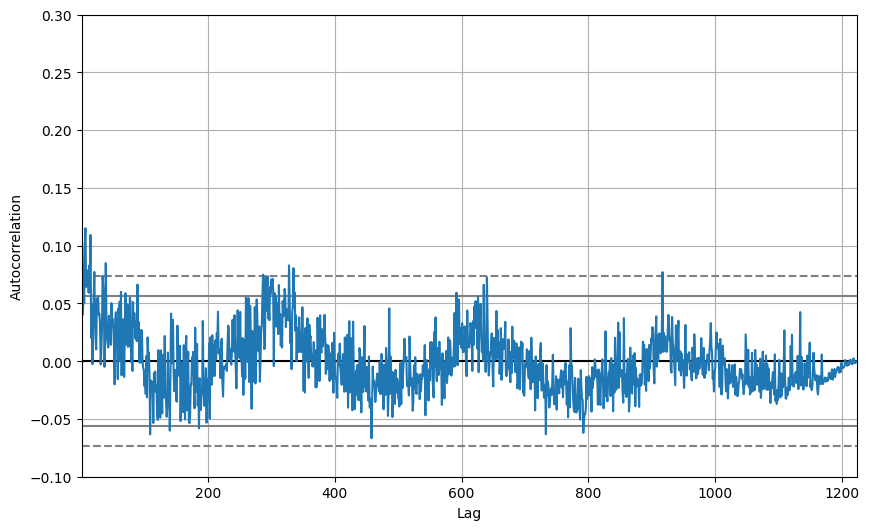

In [23]:
plt.figure(figsize=(10, 6))
pd.plotting.autocorrelation_plot(train_data['Sales'])

plt.ylim(-0.1, 0.3)

In [24]:
model = ARIMA(train_data['Sales'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                 1223
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11234.564
Date:                Wed, 19 Jun 2024   AIC                          22481.128
Time:                        23:15:03   BIC                          22511.778
Sample:                             0   HQIC                         22492.663
                               - 1223                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7958      0.021    -38.572      0.000      -0.836      -0.755
ar.L2         -0.6103      0.028    -21.631      0.000      -0.666      -0.555
ar.L3         -0.4903      0.029    -17.202      0.0

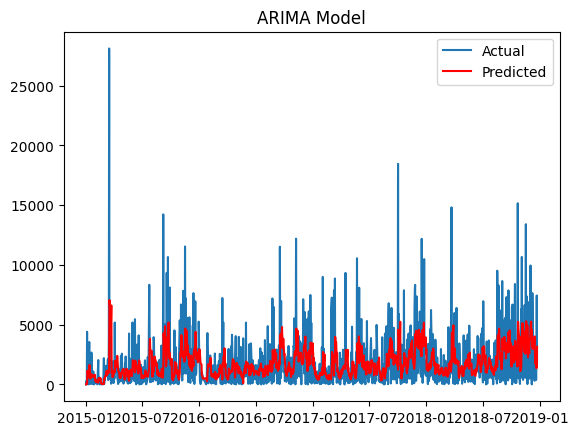

In [25]:

plt.figure()
plt.plot(train_data['Sales'], label='Actual')
plt.plot(model_fit.fittedvalues, color='red', label='Predicted')


plt.title('ARIMA Model')
plt.legend()

Residuals mean: 0    8.496976
dtype: float64
Residuals stdev: 0    2379.23053
dtype: float64


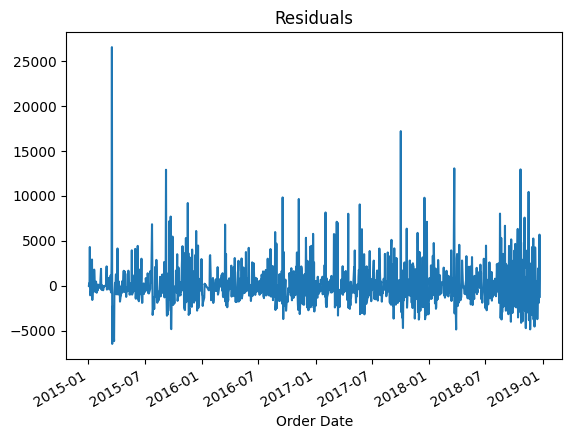

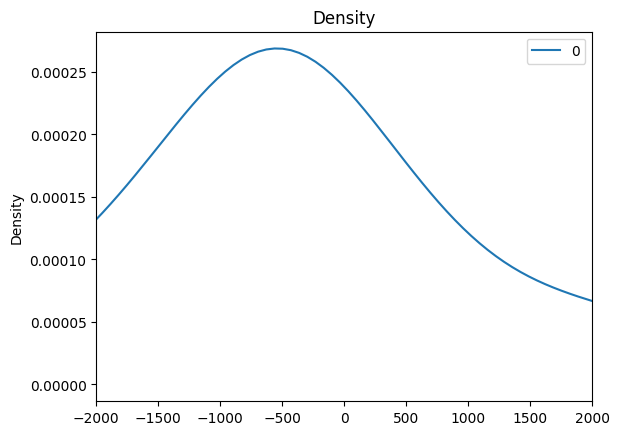

In [26]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(legend=False, title='Residuals')

residuals.plot(kind='kde', title='Density')
plt.xlim(-2000, 2000)
# Histogram plot of residuals
print(f"Residuals mean: {residuals.mean()}")
print(f"Residuals stdev: {residuals.std()}")

In [32]:
# The residuals distribution indicates a bias

In [27]:
# Predict next 7 days
forecast = model_fit.forecast(steps=7)
forecast_dates = pd.date_range(start=train_data.index[-1], periods=7, freq='D')
forecast = pd.DataFrame(forecast.values, index=forecast_dates)
forecast.columns = ['Sales']

c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


(array([17888., 17889., 17890., 17891., 17892., 17893., 17894., 17895.]),
 [Text(17888.0, 0, '2018-12-23'),
  Text(17889.0, 0, '2018-12-24'),
  Text(17890.0, 0, '2018-12-25'),
  Text(17891.0, 0, '2018-12-26'),
  Text(17892.0, 0, '2018-12-27'),
  Text(17893.0, 0, '2018-12-28'),
  Text(17894.0, 0, '2018-12-29'),
  Text(17895.0, 0, '2018-12-30')])

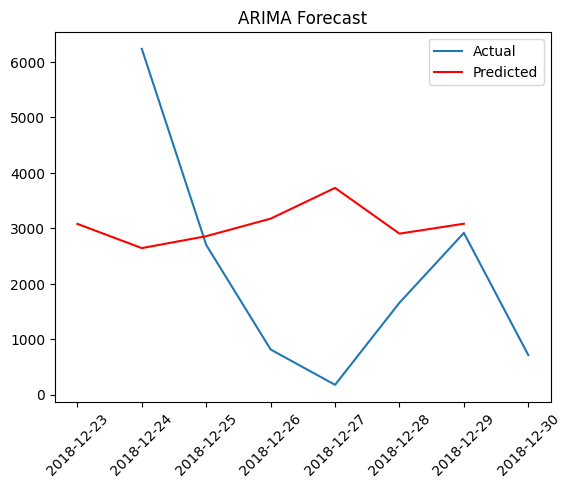

In [30]:
plt.figure()
plt.plot(df['Sales'].iloc[-7:], label='Actual')
plt.plot(forecast['Sales'], color='red', label='Predicted')
plt.title('ARIMA Forecast')

plt.legend()
plt.xticks(rotation=45)

In [31]:
# The predictions are not quite there. More parameter-tuning needed.
# I used ARIMA, this is not optimal
# SARIMAX should be used to account for seasonality trends.